In [1]:
import circle_bundles as cb
import synthetic as sy

# Generate Or Load A Synthetic Dataset

## Choose A Template

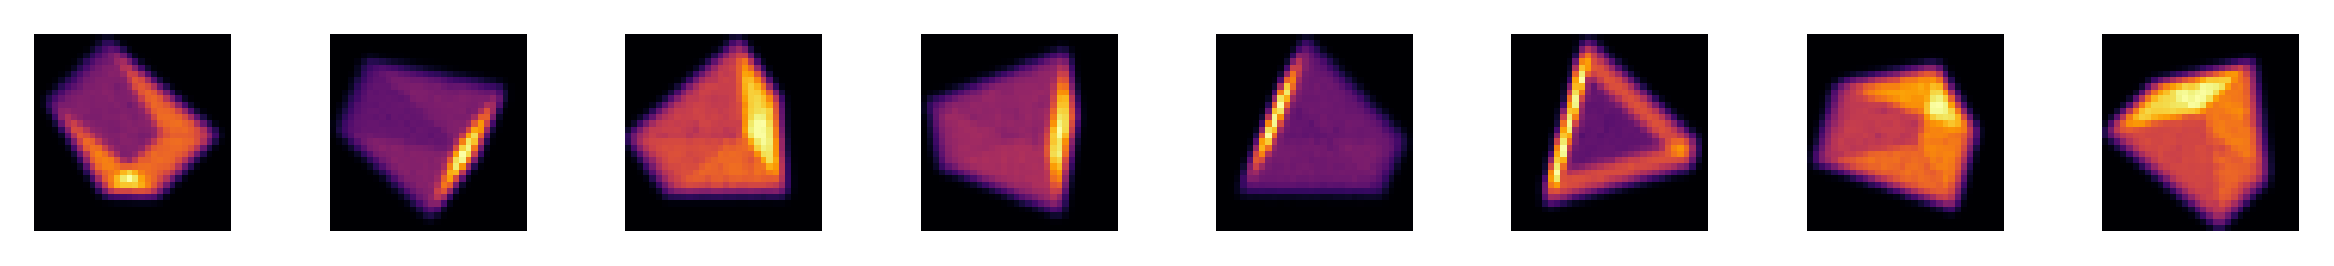

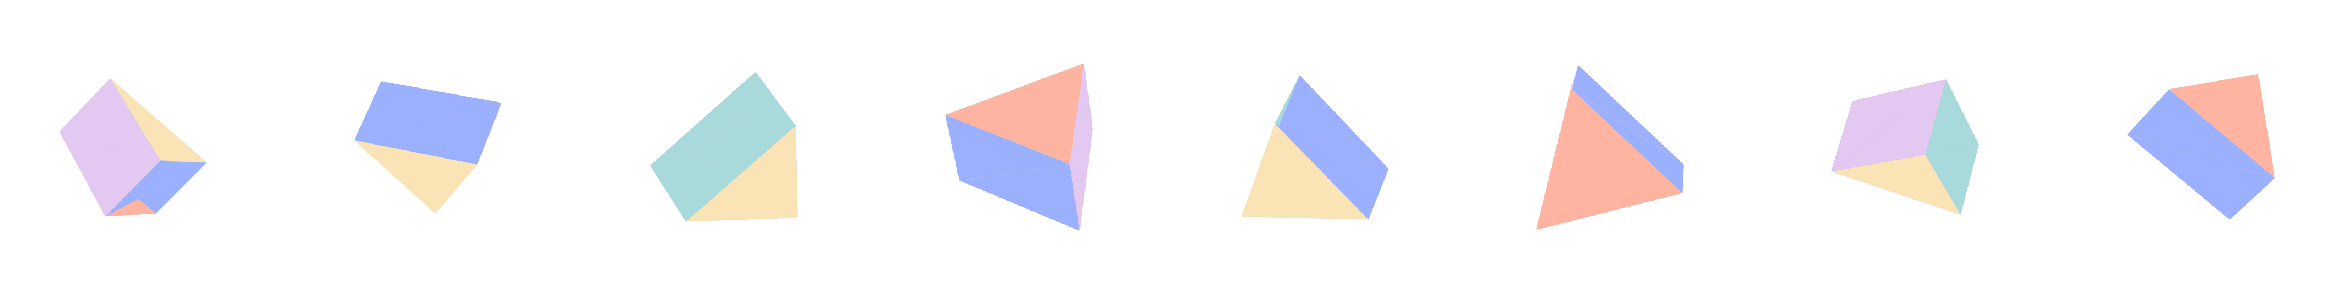

In [2]:
import matplotlib.pyplot as plt

#Get a density
p = 3
height = 1
radius = 1
grid_size = 32

mesh, face_groups = sy.make_tri_prism()
density = sy.mesh_to_density(mesh, grid_size=grid_size, sigma=0.05)

vis_func = sy.make_density_visualizer(grid_size = grid_size)
mesh_vis = sy.make_tri_prism_visualizer(mesh, face_groups,
face_colors_list = [
    '#FFB4A2',  # Rectangular Side 2 – coral blush
    '#FAE3B4',  # Soft buttery yellow
    '#A8DADC',  # Rectangular Side 1 – seafoam
    '#E3C8F2',  # Triangle Face 1 (top)
    '#9BB1FF'   # Rectangular Side 3 – pastel periwinkle
],
                                      alpha=1.0,
                                      edge_color='black',
                                      edge_width=2.5)

#View a visualization of the mesh

#SO3_data = np.array([np.eye(3).flatten()])
n_samples = 8
SO3_data = sy.sample_SO3(n_samples)[0]

density_sample = sy.rotate_density(density, SO3_data, grid_size = grid_size)
fig = cb.show_data_vis(density_sample, vis_func, max_samples = n_samples, n_cols = n_samples, sampling_method = 'first')
plt.show()

mesh_sample = sy.get_mesh_sample(mesh, SO3_data)
fig = cb.show_data_vis(mesh_sample, mesh_vis, max_samples = n_samples, n_cols = n_samples, sampling_method = 'first', pad_frac = 0.3)
plt.show()

## Generate A Dataset

In [4]:
#About 20 seconds

n_samples = 10000
SO3_data = sy.sample_SO3(n_samples)[0]

mesh_data = sy.get_mesh_sample(mesh, SO3_data)
data = sy.rotate_density(density, SO3_data, grid_size = grid_size)

print(f'Generated {n_samples} rotated triangle meshes.')

Generated 10000 rotated triangle meshes.


In [8]:
import pickle
import os
save_path = '/Users/bradturow/Desktop/Circle Bundle Code/tri_prism_data.pkl'

data_dict = {'density data': data, 'mesh data': mesh_data, 'rp2 projections': base_points}

with open(save_path, 'wb') as f:
    pickle.dump(data_dict, f)

# Get and print the file size
size_bytes = os.path.getsize(save_path)
size_mb = size_bytes / (1024 * 1024)
print(f"Saved to '{save_path}' ({size_mb:.2f} MB)")


Saved to '/Users/bradturow/Desktop/Circle Bundle Code/tri_prism_data.pkl' (2501.60 MB)


## ...Or Load A Dataset

In [ ]:
import pickle
save_path = '/Users/bradturow/Desktop/TDA/untitled folder/tri_prism_densities.pkl'

with open(save_path, 'rb') as f:
    [data, mesh_data] = pickle.load(f)
    
print(data.shape)


## Preliminary Analysis

In [6]:
from synthetic.densities import get_density_axes

#Compute basepoint projections
base_points = sy.get_density_axes(data)

#Map base points to upper half sphere for visualization
base_points[base_points[:,-1] < 0] = -1*base_points[base_points[:,-1] < 0]
print('Base projections computed.')

Base projections computed.


In [ ]:
#Show a PCA visualization of the dataset
cb.show_pca(data)

In [ ]:
#Show an interactive visualization of the projection mapping
from circle_bundles import RP2UnitVectorMetric as rp2_metric

app = cb.show_bundle_vis(base_points = base_points, 
                         data  = data, 
                         base_metric = rp2_metric())
plt.show()

In [ ]:
#Run Ripser on a sample of the data

from ripser import ripser
from persim import plot_diagrams


# Run Ripser
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


# Bundle Analysis

## Open Cover

In [ ]:
#Construct an open cover of RP2
n_sd = 2
rp2_cover = cb.make_rp2_cover(base_points, n_sd = n_sd)

summ = rp2_cover.summarize(plot = True)

## Local Coordinates 

In [ ]:
#Try running circular coordinates on a single open set using Dreimac
from dreimac import CircularCoords

j= 4
n_landmarks = 200
prime = 43
fiber_data = data[rp2_cover.U[j]]
patch_angles, n_warnings, n_lmks = cb.compute_circular_coords_dreimac(fiber_data, 
                                                                      n_landmarks_init = n_landmarks, 
                                                                      CircularCoords_cls = CircularCoords)

print(f'Retries: {n_warnings}, Number of landmarks used: {n_lmks}')
cb.show_pca(fiber_data, colors = patch_angles)



In [ ]:
#Show a sample of coordinatized densities from the fiber


fig, axes = cb.circle_vis(
    fiber_data,
    patch_angles,
    vis_func,
    per_circle=8,
    angle_range=None,      
    radius=1.0,            
    extent_factor=1.2,     
    figsize=6,
    dpi=75,
    zoom=0.13,             
    circle_linewidth=1.0,
    circle_color="black",
    save_path=None,
)

plt.show()


fiber_meshes = mesh_data[rp2_cover.U[j]]
fig, axes = cb.circle_vis(
    fiber_meshes,
    patch_angles,
    mesh_vis,
    per_circle=8,
    angle_range=None,      
    radius=1.0,            
    extent_factor=1.2,     
    figsize=4,
    dpi=100,
    zoom=0.12,             
    circle_linewidth=1.0,
    circle_color="black",
    save_path=None,
)

plt.show()

## Characteristic Classes

In [ ]:
#About 45 seconds

#Compute local trivializations and characteristic classes
bundle = cb.build_bundle(
    data,
    rp2_cover,
    CircularCoords_cls=CircularCoords,  
    landmarks_per_patch = 250,
    show=True
)


In [ ]:
#Compute class persistence on the weights filtration of the nerve
pers = bundle.get_persistence(show = True)


In [ ]:
#Show some correlations of local circular coordinates
cb.attach_bundle_viz_methods()
fig = bundle.compare_trivs(align = True, ncols = 3)
plt.show()

In [ ]:
import os
import pickle
U = rp2.cover.U
pou = rp2/cover.pou
f = bundle.local_triv.f
Omega = bundle.classes.cocycle_used.Omega


bundle_artifact = {'data':data, 
                   'base_points':cover.base_points, 
                   'Omega':Omega,
                    'f':f, 
                    'U':U,
                    'pou':pou}


save_path = '/Users/bradturow/Desktop/Circle Bundle Code/Clean_Code/data/rp2_prism_bundle_artifact.pkl'

with open(save_path, 'wb') as f:
    pickle.dump(bundle_artifact, f)

# Get and print the file size
size_bytes = os.path.getsize(save_path)
size_mb = size_bytes / (1024 * 1024)
print(f"Saved to '{save_path}' ({size_mb:.2f} MB)")


In [ ]:
#Run Ripser on the dataset
from ripser import ripser
from persim import plot_diagrams
prime = 2
diagrams = ripser(F, coeff = prime, maxdim = 1, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

In [ ]:
#Compute a global coordinatization map compatible with the maximal subcomplex
#on which the characteristic class representatives are coboundaries
triv_result = bundle.get_global_trivialization()


#Show an interactive visualization of the bundle
fig = bundle.show_bundle(colors = triv_result.F)
plt.show()

In [ ]:
#Show a PCA visualization of a fat fiber labeled with images
center_ind = 579
r = 0.2
dist_mat = rp2_metric().pairwise(X = base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]
fiber_data =  bundle.data[nearby_indices]
vis_data = mesh_data[nearby_indices]

#Labeled with meshes
file_name = 'Prism fiber meshes PCA.pdf'
#save_path = folder_path + file_name
save_path = None
fig_fiber = cb.fiber_vis(fiber_data, mesh_vis, vis_data = vis_data, max_images=500, zoom=0.08, figsize=(10, 8), save_path = save_path)
plt.show()

#Labeled with density projections
file_name = 'Prism fiber densities PCA.pdf'
#save_path = folder_path + file_name
save_path = None
fig = cb.fiber_vis(fiber_data, vis_func = vis_func, max_images=500, figsize=(10, 8), zoom = 0.05, save_path = save_path)
plt.show()

#Show the base projections of the sample data
file_name = 'Prism fiber base.pdf'
#save_path = folder_path + file_name
save_path = None
fig_base = cb.base_vis(base_points, center_ind, r, dist_mat, figsize=(8, 6), use_pca = False, save_path = save_path)
plt.show()



## Nerve Visualization

In [ ]:
#Get a visualization of the 1-skeleton of the nerve, labeled by the orientation cocycle representative
node_labels = [f"{i+1}" for i in range(rp2_cover.flat_vertex_coords.shape[0])]
file_name = 'Prism Densities Nerve.pdf'
#save_path = folder_path + file_name
save_path = None
fig, axes = cb.nerve_vis(
    rp2_cover.K,
    rp2_cover.flat_vertex_coords,
    cochains={1:bundle.classes.sw1_O1},
    base_colors={0:'black', 1:'black', 2:'pink'}, 
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}},
    opacity=0,
    node_size=18,
    node_labels=node_labels,
    fontsize=8,
    font_color = 'white',
    save_path=save_path,
    title='1-Skeleton Of The Nerve Of The Cover'
)
plt.show()

In [ ]:
#Show a visualization of the nerve labeled with meshes
dist_mat = rp2_metric().pairwise(X = rp2_cover.landmarks, Y = rp2_cover.base_points)
inds = np.argmin(dist_mat, axis = 1)
node_data = mesh_data[inds]

node_labels = [f"{i+1}" for i in range(rp2_cover.flat_vertex_coords.shape[0])]
file_name = 'Prism Densities Full Nerve.pdf'
save_path = folder_path + file_name
save_path = None

fig, axes = cb.nerve_vis(
    rp2_cover.K,
    rp2_cover.flat_vertex_coords,
    cochains={1:bundle.classes.sw1_O1},
    base_colors={0:'black', 1:'black', 2:'pink'},
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}},
    opacity=0,
    node_size=24,
    line_width=1,
    node_labels=None,
    fontsize=8,
    font_color='white',
    vis_func=mesh_vis,
    data=node_data,
    image_zoom=0.07,
    save_path=save_path,
    title='1-Skeleton Of The Nerve Of The Cover'
)



In [ ]:
#Show a visualization of the nerve labeled with density projections

#Get samples to display at nodes
node_data = bundle.data[inds]

node_labels = [f"{i+1}" for i in range(rp2_cover.flat_vertex_coords.shape[0])]
file_name = 'Prism Densities Full Nerve.pdf'
save_path = folder_path + file_name
save_path = None

fig, axes = cb.nerve_vis(
    rp2_cover.K,
    rp2_cover.flat_vertex_coords,
    cochains={1:bundle.classes.sw1_O1},
    base_colors={0:'black', 1:'black', 2:'pink'},
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}},
    opacity=0,
    node_size=24,
    line_width=1.2,
    node_labels=None,
    fontsize=8,
    font_color='white',           
    vis_func=vis_func,
    data=node_data,
    image_zoom=0.05,
    save_path=save_path,
    title='1-Skeleton Of The Nerve Of The Cover'
)
plt.show()

# Restriction To An Equator

In [ ]:
#Get patches whose projection lie near the equator in RP2
eps = 0.1
eq_inds = np.abs(base_points[:,-1]) < eps
eq_data = bundle.data[eq_inds]
eq_base_angles = np.arctan2(base_points[eq_inds,1], base_points[eq_inds,0]) % (np.pi)


In [ ]:
#Get a visualization of the data arranged by assigned coordinates, using meshes
coords = np.array([eq_base_angles, triv_result.F[eq_inds]]).T
file_name = 'prism KB meshes.pdf'
save_path = folder_path + file_name
save_path = None

fig = cb.lattice_vis(
    mesh_data[eq_inds],
    coords,
    mesh_vis, 
    per_row=7,          
    per_col=7,          
    figsize=10, 
    thumb_px=100,
    dpi=200,
    save_path=None
)
plt.show()

#Get a visualization of the data arranged by assigned coordinates, using densities
file_name = 'prism KB densities.pdf'
save_path = folder_path + file_name
save_path = None

fig = cb.lattice_vis(
    eq_data,
    coords,
    vis_func, 
    per_row=7,          
    per_col=7,          
    figsize=12, 
    thumb_px=150,
    dpi=200,
    save_path=None
)
plt.show()


In [ ]:
#FIX:  ISOLATED NODES SHOULD NOT LOOK THE SAME AS EQUATOR NODES

#Show a visualization of the maximal subcomplex of N(U) on which the class representatives become coboundaries
file_name = 'Prism Density Restricted Nerve.pdf'
save_path = folder_path + file_name
save_path = None


#Highlight the open sets which contain equator points
eq_sets = np.flatnonzero(rp2_cover.U[:, eq_inds].any(axis=1))
max_triv = cb.max_trivial_to_simplex_tree(bundle.get_max_trivial_subcomplex())
sub_verts = sorted({v for s,_ in max_triv.get_filtration() if len(s)==1 for v in s})
highlight_cochain = {(j,): int(j in set(eq_sets)) for j in sub_verts}

node_labels = [f"{i+1}" for i in range(rp2_cover.flat_vertex_coords.shape[0])]

fig, axes = cb.nerve_vis(
    max_triv,
    rp2_cover.flat_vertex_coords,
    cochains={1:bundle.classes.sw1_O1, 0:highlight_cochain},
    base_colors={0:'black', 1:'black', 2:'pink'}, 
    cochain_cmaps={1:{1: 'darkblue', -1:'darkred'}, 0:{0: 'darkgray', 1: 'black'}},
    opacity=0,
    node_size=12,
    node_labels=node_labels,
    fontsize=8,
    font_color = 'white',
    save_path=save_path,
    title=None
)
plt.show()


In [ ]:
#Show a visualization of the maximal subcomplex of N(U) on which the class representatives become coboundaries
file_name = 'Prism Density Restricted Nerve With Images.pdf'
save_path = folder_path + file_name
save_path = None

dist_mat = RP2UnitVectorMetric().pairwise(X = rp2_cover.landmarks, Y = rp2_cover.base_points)
inds = np.argmin(dist_mat, axis = 1)
node_data = mesh_data[inds]


#Highlight the open sets which contain equator points
eq_sets = np.flatnonzero(rp2_cover.U[:, eq_inds].any(axis=1))
max_triv = cb.max_trivial_to_simplex_tree(bundle.get_max_trivial_subcomplex())
sub_verts = sorted({v for s,_ in max_triv.get_filtration() if len(s)==1 for v in s})
highlight_cochain_sub = {(j,): int(j in set(eq_sets)) for j in sub_verts}

node_labels = [f"{i+1}" for i in range(rp2_cover.flat_vertex_coords.shape[0])]

fig, axes = cb.nerve_vis(
    max_triv,
    rp2_cover.flat_vertex_coords,
    cochains={1:bundle.classes.sw1_O1, 0:highlight_cochain},
    base_colors={0:'black', 1:'black', 2:'pink'},
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}, 0:{0: 'darkgray', 1: 'black'}},
    opacity=0,
    node_size=24,
    line_width=1,
    node_labels=None,
    fontsize=8,
    font_color='white',
    vis_func=mesh_vis,
    data=node_data,
    image_zoom=0.07,
    save_path=save_path,
    title=None
)
plt.show()


# Optional -- Equator Bundle

In [ ]:
#Construct a new bundle along the equator in RP2
eps = 0.15
eq_inds = np.abs(base_points[:,-1]) < eps

eq_data = bundle.data[eq_inds]

eq_base_angles = np.arctan2(base_points[eq_inds,1], base_points[eq_inds,0]) % (np.pi)
eq_base_points = np.array([np.cos(eq_base_angles), np.sin(eq_base_angles)]).T

#Set up an open cover of the base circle
n_landmarks = 12
lmk_angs = np.linspace(0, np.pi, n_landmarks, endpoint= False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.99
radius = overlap* np.pi/(2*n_landmarks)

from circle_bundles.metrics import RP1UnitVectorMetric

eq_cover = cb.MetricBallCover(eq_base_points, landmarks, radius, metric = RP1UnitVectorMetric())
eq_cover_data = eq_cover.build()

#Construct local circular coordinates and model transitions as O(2) matrices
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    CircularCoords_cls=CircularCoords,
    show=True,
)


eq_mesh_data = mesh_data[eq_inds]


In [ ]:
#Show a PCA visualization of the equator data
cb.show_pca(eq_data)

In [ ]:
#Show an interactive visualization of the equator data
fig = eq_bundle.show_bundle()
plt.show()

In [ ]:
#Compute global coordinates on equator data using a filtration of the nerve
eq_triv_result = eq_bundle.get_global_trivialization()
print('Global coordinates computed.')

In [ ]:
#Compute a potential for the restricted orientation class
eq_subcomplex = eq_bundle.get_max_trivial_subcomplex()
edges = eq_subcomplex.kept_edges
Omega = eq_bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = eq_bundle.classes.omega_O1_used


file_name = 'Tri prism equator nerve.pdf'
save_path = folder_path + file_name
save_path = None

fig = eq_bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()




In [ ]:
#Get a visualization of the data arranged by assigned coordinates using meshes
coords = np.array([eq_base_angles, eq_triv_result.F]).T

file_name = 'Prism eq KB meshes.pdf'
save_path = folder_path + file_name
save_path = None

fig = cb.lattice_vis(
    eq_mesh_data,
    coords,
    mesh_vis, 
    per_row=7,          
    per_col=7,          
    figsize=10, 
    thumb_px=100,
    dpi=200,
    save_path=None
)
plt.show()


#Get a visualization of the data arranged by assigned coordinates using meshes
file_name = 'Prism eq KB densities.pdf'
save_path = folder_path + file_name
save_path = None

fig = cb.lattice_vis(
    eq_data,
    coords,
    vis_func, 
    per_row=7,          
    per_col=7,          
    figsize=12, 
    thumb_px=150,
    dpi=200,
    save_path=None
)
plt.show()
